* TODO check DO - disease ontology features/inputs


##### Modify from base to. do regression target !
Load in proc data from prev notebook.
* How many children a disease has 

`./proc/{...}`

* Checking for _genetic basis_ of diseases - all diseases from OMIM are genetic, single? 
    * Maybe aklso Orphanet?? 
    
* Check in subset of diseases with `inherited, genetic, Autosomal, recessive, x-link, dominant, congenital`, in name/desc

* try model without indirect ev, may be leak

"However, evidence can sometimes be informative to discriminate targets in similar diseases or phenotypes. For example, when evaluating the inflammatory bowel disease and NOD2 association, other pieces of evidence describing the relationship between Crohn's disease and NOD2 might as well be informative. To approach this problem systematically, the Platform makes use of the properties of the disease ontology (EFO), to select all evidence referring to NOD2 in the context of inflammatory bowel disease or any of its ontology descendants (including Crohn's disease). This type of associations is referred in the platform as indirect associations

* Do train/test split by parent ancestor group , top level
    * By 1 level down (max is 10% for one group) - ~ similar res: 82 vs 83 auc
* Do histogram of pred scores distrib

* get error by source / cat e.g. orphanet
     * Done

* check consistency +- drop duplicates by disease name
    * Model results are about same - 83 AUC

* פירוק לפי דימפטומים, תופעות לוואי, by phenotypes
* count total evidence by source (e.g. # somatic, genetic, etc) + fraction of total from them - for interpretability

---------------

* Using 0/1 instead of evidence score: no change (both get 83.2 AUC on random split)
* Including associated evidence: 93 auc (over ~83)

* Keeping vs dropping `source` col for model (when using grouped by `name`) - 83 vs 79 auc



---- 

* Add single feature model - by source
    * 55.5 AUC
* OPT: eval by source? LOO (for top groups)
* For predicted to have children - plot distribution of actual # children

In [83]:
import pandas as pd

import ast # parse list, etc dtype cols
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import f_classif, chi2,SelectFromModel, f_regression, mutual_info_regression, SelectKBest
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV, ElasticNet, ElasticNetCV, RidgeCV,ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score,GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestRegressor
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import *
from sklearn.feature_selection import SelectFpr, SelectFdr
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [84]:
def regression_metrics(y_true,y_pred,return_results=False):
    print()
    mae = round(mean_absolute_error(y_true = y_true,y_pred=y_pred),2)
    r2 = round(r2_score(y_true = y_true,y_pred=y_pred),2)
    print("MAE (Mean absolute error): %.2f" %(mae))
    print("Median absolute error %.2f" %(median_absolute_error(y_true = y_true,y_pred=y_pred)))
    print("RMSE %.2f" %(mean_squared_error(y_true = y_true,y_pred=y_pred,squared=False)))  
    print("R2 %.2f" %(r2))
    try:
        print("MAPE mean absolute percentage error %.3f" %(mean_absolute_percentage_error(y_true = y_true,y_pred=y_pred)))
    except:()
    if return_results:
        return  (mae, r2)##({"mae":mae, "r2":r2})


In [85]:
USE_ASSOC = False ## don't use associated evidence (may be leak). ~ 83 (without) vs 93 with it
GET_PREDS = True#False

GRPBY_NAME = True # keep 1 row per name. Changes # data, embedding learning, use name instead of id for joining..

DO_SVD = False # keep raw inputs. MANY cols!!

NAN_THRESH = 20 # drop cases with less than this many occs. Reduces model perf, but saves on size/mem

DO_LEAKY_FS = False#True # leaky train on train feature sel.. 

In [86]:
# dirs = [
# ## todo: rerun with evidences
#         './go',
        
#  './evidence',
#  './evidence/sourceId=chembl',
#  './evidence/sourceId=cancer_gene_census',
#  './evidence/sourceId=europepmc',
#  './evidence/sourceId=crispr',
#  './evidence/sourceId=cancer_biomarkers',
#  './evidence/sourceId=clingen',
#  './diseaseToPhenotype',
#  './targets',
#  './associationByDatasourceDirect',
#  './fda',
#  './fda/significantAdverseDrugReactions',
#  './mechanismOfAction',
#  './indication',
#  './associationByOverallDirect',
#  './associationByOverallIndirect',
#  './diseases',
#  './mousePhenotypes',
#  './molecule',
#  './hpo',
#  './interaction'
#        ]


dirs = [
#     './drugWarnings',
 './diseases',
'./diseaseToPhenotype',
     './associationByOverallDirect',
 './targets',
    './hpo',]

In [87]:
# # https://stackoverflow.com/questions/70009192/how-to-solve-the-issue-of-malformed-node-or-string-error-in-pandas
# import ast

# def ddpe(lst_val):
#     """
#     + If the column values are lists already:
#     https://stackoverflow.com/questions/70009192/how-to-solve-the-issue-of-malformed-node-or-string-error-in-pandas
#     """
#     # return NaN is value is not a list. 
#     # Assuming those are only the two options.
#     if not isinstance(lst_val, list):   
#         return np.nan  
#     return list(dict.fromkeys(lst_val))

def ddpe(str_val):
    """
    https://stackoverflow.com/questions/70009192/how-to-solve-the-issue-of-malformed-node-or-string-error-in-pandas
    """
    if pd.isna(str_val):  # return NaN if value is NaN
        return np.nan  
    # Remove the square brackets, split on ',' and strip possible
    # whitespaces between elements   
    vals = [v.strip() for v in str_val.strip('[]').split(',')]
    # remove duplicates keeping the original order
    return list(dict.fromkeys(vals)) # ORIG
#     return dict.fromkeys(vals)
# ### doesn't work yet here
# # df["synonyms"].apply(ddpe)
# # df.assign(**pd.DataFrame(df["synonyms"].apply(ddpe)))
# # df.assign(**pd.DataFrame(df["synonyms"].apply(ddpe).values.tolist())) # stuck?

In [88]:
# %%time
# # # pd.read_parquet('./proc/molecule.parquet')
# # pd.read_parquet('./evidence/sourceId=cancer_biomarkers')
# df_evidence = pd.read_parquet('./proc/evidence.parquet').dropna(thresh=30,axis=1) ## big file
# print(df_evidence.shape)
# print(df_evidence.nunique())
# display(df_evidence)

#### Diseases raw data
* Doesn't include "features"
* some cols are a list, others an unparsed list. 

* `synonyms` is a dict
    * https://stackoverflow.com/questions/39640936/parsing-a-dictionary-in-a-pandas-dataframe-cell-into-new-row-cells-new-columns

In [89]:
df = pd.read_parquet("./proc/diseases.parquet").dropna(how="all",axis=1)
df = df.drop(columns=["code","directLocationIds","sko"],errors="ignore") ## ,"synonyms"
df

,id,description,name,parents,synonyms,ancestors,descendants,children,therapeuticAreas,ontology
0,DOID_7551,A primary bacterial infectious disease that is...,gonorrhea,['EFO_0003955' 'MONDO_0000314'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['EFO_0000512' 'EFO_0009663' 'MONDO_0100336' '...,[],[],['MONDO_0100336' 'OTAR_0000017' 'EFO_0005741' ...,"{'isTherapeuticArea': False, 'leaf': True, 'so..."
1,HP_0000031,The presence of inflammation of the epididymis.,Epididymitis,['HP_0012649' 'HP_0000022'],None,['HP_0000022' 'HP_0000078' 'EFO_0000651' 'HP_0...,[],[],['EFO_0000651'],"{'isTherapeuticArea': False, 'leaf': True, 'so..."
2,HP_0000857,None,Neonatal insulin-dependent diabetes mellitus,['EFO_0000400' 'HP_0001952' 'HP_0000818'],None,['HP_0000818' 'HP_0000118' 'OTAR_0000020' 'HP_...,[],[],['OTAR_0000020' 'EFO_0000651' 'EFO_0001379' 'E...,"{'isTherapeuticArea': False, 'leaf': True, 'so..."
3,HP_0001693,Pattern of blood flow in the heart that deviat...,Cardiac shunt,['HP_0011028'],None,['EFO_0000651' 'HP_0011028' 'HP_0000118' 'HP_0...,['HP_0012382'],['HP_0012382'],['EFO_0000651'],"{'isTherapeuticArea': False, 'leaf': False, 's..."
4,HP_0001730,A progressive form of hearing impairment.,Progressive hearing impairment,['HP_0000364'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['HP_0000364' 'EFO_0000651' 'HP_0000598' 'HP_0...,['HP_0000408'],['HP_0000408'],['EFO_0000651'],"{'isTherapeuticArea': False, 'leaf': False, 's..."
...,...,...,...,...,...,...,...,...,...,...
23069,Orphanet_721,Gray platelet syndrome (GPS) is a rare inherit...,Gray platelet syndrome,['Orphanet_98455'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['Orphanet_183654' 'OTAR_0000018' 'Orphanet_98...,[],[],['OTAR_0000018' 'EFO_0005803'],"{'isTherapeuticArea': False, 'leaf': True, 'so..."
23070,Orphanet_93322,Tibial hemimelia is a rare congenital anomaly ...,Tibial hemimelia,['Orphanet_2130'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['EFO_0004260' 'Orphanet_404571' 'OTAR_0000006...,['Orphanet_295079' 'Orphanet_295077'],['Orphanet_295077' 'Orphanet_295079'],['OTAR_0000006' 'OTAR_0000018'],"{'isTherapeuticArea': False, 'leaf': False, 's..."
23071,Orphanet_93925,Alobar holoprosencephaly is the most severe cl...,Alobar holoprosencephaly,['Orphanet_2162'],None,['Orphanet_183763' 'Orphanet_183533' 'OTAR_000...,[],[],['OTAR_0000018' 'EFO_0001379'],"{'isTherapeuticArea': False, 'leaf': True, 'so..."
23072,Orphanet_98539,None,Early-onset ataxia with dementia,['Orphanet_98538'],None,['Orphanet_71859' 'Orphanet_183500' 'Orphanet_...,['Orphanet_247815' 'EFO_0009016' 'EFO_0010249'...,['Orphanet_1172'],['OTAR_0000018' 'EFO_0000618'],"{'isTherapeuticArea': False, 'leaf': False, 's..."


In [90]:
## synonyms is a dict of lists and has nans when missing. I do this as a proxy feature (better would be to count the # of synonyms, but skip)
df["hasBroadSynonym"] = ((~df["synonyms"].astype(str).str.contains("'hasBroadSynonym': None")) & (~df["synonyms"].isna())).astype(int)
df["hasExactSynonym"] = ((~df["synonyms"].astype(str).str.contains("'hasExactSynonym': None")) & (~df["synonyms"].isna())).astype(int)
df["hasRelatedSynonym"] = ((~df["synonyms"].astype(str).str.contains("'hasRelatedSynonym': None")) & (~df["synonyms"].isna())).astype(int)
df.columns

Index(['id', 'description', 'name', 'parents', 'synonyms', 'ancestors',
       'descendants', 'children', 'therapeuticAreas', 'ontology',
       'hasBroadSynonym', 'hasExactSynonym', 'hasRelatedSynonym'],
      dtype='object')

##### drop lab measurements
* Also drop these in the feature extraction bits later
* May need to validate that these are indeed not diseases! ? 

In [91]:
print(df.shape[0])
df = df.loc[~df["name"].str.contains("volume|measurement",case=False)] # 2800 - 10% of dara
print(df.shape[0])

23074
20265


* Could try also `data=ast.literal_eval(str(map(str,datas.split(','))))`
* there's errors due to `   ['MONDO_0008965' 'MONDO_0009814' 'MONDO_0002182' ... 'MONDO_0014176'`

In [92]:
df.head()["ancestors"].str.split(" ").str.len()

0    12
1     7
2    14
3     5
4     4
Name: ancestors, dtype: int64

In [93]:
# df["descendants"].apply(ast.literal_eval)
# df["has_children"] = (df["children"].apply(ast.literal_eval).apply(lambda x: len(x))>0).astype(int) # ORIG
df["has_children"] = df["children"].str.split(" ").str.len()-1
df["has_children"] = df["has_children"].clip(upper=100) # large range
# df["num_parents"] = df["parents"].apply(ast.literal_eval).apply(lambda x: len(x)) #OLD
# df["num_ancestors"] = df["ancestors"].apply(ast.literal_eval).apply(lambda x: len(x))#OLD
df["num_parents"] = df["parents"].str.split(" ").str.len()-1
df["num_ancestors"] = df["ancestors"].str.split(" ").str.len()-1

df["num_therapeuticAreas"] = df["therapeuticAreas"].apply(lambda x: len(x)) # parsed already as list


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [94]:
df.describe().round(1)

,hasBroadSynonym,hasExactSynonym,hasRelatedSynonym,has_children,num_parents,num_ancestors,num_therapeuticAreas
count,20265.0,20265.0,20265.0,20265.0,20265.0,20265.0,20265.0
mean,0.0,0.8,0.3,1.2,0.7,10.4,32.6
std,0.1,0.4,0.5,5.3,1.1,8.5,17.6
min,0.0,0.0,0.0,0.0,0.0,0.0,14.0
25%,0.0,1.0,0.0,0.0,0.0,4.0,16.0
50%,0.0,1.0,0.0,0.0,0.0,8.0,31.0
75%,0.0,1.0,1.0,0.0,1.0,14.0,45.0
max,1.0,1.0,1.0,100.0,12.0,70.0,147.0


In [95]:
# # ###leak for target)
## min is 1 due to [[]]: 
df["num_children"] = df["children"].str.split(" ").str.len()#-1
df["num_descendants"] = df["descendants"].str.split(" ").str.len()#-1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [96]:
df.loc[df["has_children"]==1]

,id,description,name,parents,synonyms,ancestors,descendants,children,therapeuticAreas,ontology,hasBroadSynonym,hasExactSynonym,hasRelatedSynonym,has_children,num_parents,num_ancestors,num_therapeuticAreas,num_children,num_descendants
7,MONDO_0002171,"A benign, intermediate, or malignant tumor tha...",giant cell tumor,['EFO_0000616'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['MONDO_0023370' 'MONDO_0045024' 'EFO_0000616'],['EFO_1000281' 'MONDO_0002402' 'MONDO_0003561'...,['MONDO_0002402' 'EFO_1000562'],['MONDO_0045024'],"{'isTherapeuticArea': False, 'leaf': False, 's...",0,1,1,1,0,2,17,2,5
39,MONDO_0002070,The presence of a defect (opening) in the sept...,ventricular septal defect,['MONDO_0002078' 'EFO_0000508'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['OTAR_0000018' 'EFO_0003777' 'MONDO_0024239' ...,['MONDO_0020387' 'MONDO_0013746' 'MONDO_002038...,['MONDO_0013746' 'MONDO_0018089'],['OTAR_0000018' 'EFO_0000319'],"{'isTherapeuticArea': False, 'leaf': False, 's...",0,1,1,1,1,6,30,2,5
48,MONDO_0009319,Pantothenate kinase-associated neurodegenerati...,pantothenate kinase-associated neurodegeneration,['MONDO_0017760' 'MONDO_0020240' 'MONDO_001811...,"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['MONDO_0002025' 'MONDO_0021084' 'EFO_0004280'...,['MONDO_0016304' 'MONDO_0016305'],['MONDO_0016304' 'MONDO_0016305'],['MONDO_0002025' 'OTAR_0000020' 'MONDO_0024458...,"{'isTherapeuticArea': False, 'leaf': False, 's...",0,1,1,1,6,42,78,2,2
70,MONDO_0000565,Infective endocarditis (IE) is an infection of...,infective endocarditis,['EFO_0005741' 'EFO_0000465'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['MONDO_0100336' 'EFO_0003777' 'EFO_0005741' '...,['EFO_1001193' 'EFO_1000830'],['EFO_1000830' 'EFO_1001193'],['MONDO_0100336' 'EFO_0005741' 'EFO_0000319'],"{'isTherapeuticArea': False, 'leaf': False, 's...",0,1,1,1,1,6,45,2,2
101,MONDO_0002108,A malignant neoplasm involving the thyroid gland,thyroid cancer,['MONDO_0021069' 'EFO_0003841'],{'hasBroadSynonym': array(['thyroid gland neop...,['EFO_0003769' 'EFO_0001379' 'EFO_0003841' 'MO...,['EFO_1000590' 'EFO_1000593' 'Orphanet_247698'...,['MONDO_0019962' 'EFO_0002892'],['EFO_0001379' 'MONDO_0045024'],"{'isTherapeuticArea': False, 'leaf': False, 's...",1,1,0,1,1,8,31,2,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23041,Orphanet_79238,"Galactose epimerase deficiency is a very rare,...",Galactose epimerase deficiency,['Orphanet_352'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['Orphanet_98056' 'Orphanet_98710' 'OTAR_00000...,['Orphanet_308473' 'Orphanet_308487'],['Orphanet_308473' 'Orphanet_308487'],['OTAR_0000020' 'EFO_0009690' 'MONDO_0024458' ...,"{'isTherapeuticArea': False, 'leaf': False, 's...",0,1,0,1,0,25,75,2,2
23046,Orphanet_98631,None,Secondary dysgenetic glaucoma,['Orphanet_359'],None,['Orphanet_359' 'Orphanet_101435' 'OTAR_000001...,['Orphanet_98981' 'Orphanet_77' 'Orphanet_9897...,['Orphanet_98632' 'Orphanet_98637'],['OTAR_0000018' 'MONDO_0024458'],"{'isTherapeuticArea': False, 'leaf': False, 's...",0,0,0,1,0,7,32,2,21
23052,Orphanet_371157,None,Congenital disorder of glycosylation with hepa...,['Orphanet_101940'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['OTAR_0000018' 'Orphanet_101940' 'EFO_0000508...,['Orphanet_324422' 'Orphanet_329178'],['Orphanet_324422' 'Orphanet_329178'],['OTAR_0000018' 'EFO_0010282'],"{'isTherapeuticArea': False, 'leaf': False, 's...",0,1,0,1,0,5,30,2,2
23054,Orphanet_422,Idiopathic and/or familial pulmonary arterial ...,Idiopathic and/or familial pulmonary arterial ...,['MONDO_0017148' 'Orphanet_156610'],None,['MONDO_0000473' 'OTAR_0000018' 'MONDO_0005149...,['Orphanet_275777' 'Orphanet_275766'],['Orphanet_275766' 'Orphanet_275777'],['OTAR_0000018' 'OTAR_0000010' 'EFO_0009690' '...,"{'isTherapeuticArea': False, 'leaf': False, 's...",0,0,0,1,1,21,59,2,2


count    4686.0
mean        5.8
std         6.8
min         2.0
25%         2.0
50%         3.0
75%         6.0
max        40.0
Name: num_children, dtype: float64


<AxesSubplot:>

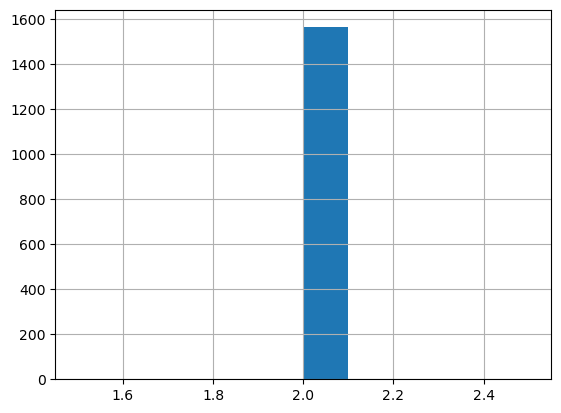

In [97]:
print(df.loc[df["has_children"]>0]["num_children"].clip(upper=40).describe().round(1))
df.loc[df["has_children"]==1]["num_children"].clip(upper=40).hist()

In [98]:
# df.loc[df["num_parents"]<=0]
df.loc[df["num_ancestors"]<=0]

,id,description,name,parents,synonyms,ancestors,descendants,children,therapeuticAreas,ontology,hasBroadSynonym,hasExactSynonym,hasRelatedSynonym,has_children,num_parents,num_ancestors,num_therapeuticAreas,num_children,num_descendants
90,GO_0016043,None,cellular component organization,['GO_0008150'],None,['GO_0008150'],['GO_0007051' 'GO_0007052' 'GO_0006996' 'GO_00...,['GO_0006996'],['GO_0008150'],"{'isTherapeuticArea': False, 'leaf': False, 's...",0,0,0,0,0,0,14,1,4
286,MONDO_0009467,None,natal teeth-intestinal pseudoobstruction-paten...,['OTAR_0000018'],"{'hasBroadSynonym': None, 'hasExactSynonym': N...",['OTAR_0000018'],[],[],['OTAR_0000018'],"{'isTherapeuticArea': False, 'leaf': True, 'so...",0,0,1,0,0,0,16,1,1
337,GO_0007600,The series of events required for an organism ...,sensory perception,['GO_0008150'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['GO_0008150'],['GO_0050909' 'GO_0007605' 'GO_0007601' 'GO_00...,['GO_0007601' 'GO_0007605' 'GO_0007608' 'GO_00...,['GO_0008150'],"{'isTherapeuticArea': False, 'leaf': False, 's...",0,1,0,4,0,0,14,5,7
387,MONDO_0010798,Proximal tubulopathy-diabetes mellitus-cerebel...,proximal tubulopathy-diabetes mellitus-cerebel...,['OTAR_0000018'],"{'hasBroadSynonym': None, 'hasExactSynonym': N...",['OTAR_0000018'],[],[],['OTAR_0000018'],"{'isTherapeuticArea': False, 'leaf': True, 'so...",0,0,1,0,0,0,16,1,1
448,GO_0008150,The activities of living organisms that suppor...,biological process,[],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",[],['GO_0044062' 'GO_0046483' 'GO_2000428' 'GO_00...,['GO_0000003' 'GO_0006766' 'GO_0007568' 'GO_00...,['GO_0008150'],"{'isTherapeuticArea': True, 'leaf': False, 'so...",0,1,0,42,0,0,14,43,646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19540,EFO_1000048,Pig disease caused by porcine circovirus type ...,postweaning multisystemic wasting syndrome,['EFO_0005932'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['EFO_0005932'],[],[],['EFO_0005932'],"{'isTherapeuticArea': False, 'leaf': True, 'so...",0,1,0,0,0,0,15,1,1
19572,EFO_0009263,Quantification of symptom associated with nico...,nicotine withdrawal symptom count,['EFO_0001444'],None,['EFO_0001444'],[],[],['EFO_0001444'],"{'isTherapeuticArea': False, 'leaf': True, 'so...",0,0,0,0,0,0,15,1,1
19826,EFO_1000922,Disease caused by the liberation of exotoxins ...,enterotoxemia,['EFO_0005932'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['EFO_0005932'],[],[],['EFO_0005932'],"{'isTherapeuticArea': False, 'leaf': True, 'so...",0,1,0,0,0,0,15,1,1
19895,EFO_0008352,quantification of the presence or absence of C...,C9orf72 mutation status,['EFO_0001444'],None,['EFO_0001444'],[],[],['EFO_0001444'],"{'isTherapeuticArea': False, 'leaf': True, 'so...",0,0,0,0,0,0,15,1,1


Top level diseases (?) - use these for filtering groups for validation
* Not - these are very high level! Maybe use a level under them? 


* There are some super common ones, we drop them since we want a level under maybe ? 
* e.g. OTAR_0000018 - "genetic, familial or congenital disease" - 26%, 
OTAR_0000006 - (musculoskeletal or connective tissue disease
) 15%. (the rest are 5% and under)

In [99]:
display(df.loc[df['num_parents']==0])
ZERO_LEVEL_NODES_LIST = list(df.loc[df['num_parents']==0]["id"])
print(len(ZERO_LEVEL_NODES_LIST)," #ZERO_LEVEL_NODES_LIST")

## cases with just 1 ancestor, i.e one level down
## broken due to ancestors not being counted
ONE_LEVEL_NODES_LIST = list(df.loc[(df['num_ancestors']<=2)]["id"]) # maybe expand to handle 0 ases or pairs of ancestor at first split? 
print(len(ONE_LEVEL_NODES_LIST)," #ONE_LEVEL_NODES_LIST")

ONE_LEVEL_NODES_LIST = [ i for i in ONE_LEVEL_NODES_LIST if i != "OTAR_0000018"] ## צשמושךךט גרםפ 2 הקרט יןעי ךקהקך םמקד
ONE_LEVEL_NODES_LIST = [ i for i in ONE_LEVEL_NODES_LIST if i != "OTAR_0000006"]
pattern = '|'.join(ONE_LEVEL_NODES_LIST)
print(len(ONE_LEVEL_NODES_LIST)," #ONE_LEVEL_NODES_LIST")

# ZERO_LEVEL_NODES_LIST
pattern

,id,description,name,parents,synonyms,ancestors,descendants,children,therapeuticAreas,ontology,hasBroadSynonym,hasExactSynonym,hasRelatedSynonym,has_children,num_parents,num_ancestors,num_therapeuticAreas,num_children,num_descendants
3,HP_0001693,Pattern of blood flow in the heart that deviat...,Cardiac shunt,['HP_0011028'],None,['EFO_0000651' 'HP_0011028' 'HP_0000118' 'HP_0...,['HP_0012382'],['HP_0012382'],['EFO_0000651'],"{'isTherapeuticArea': False, 'leaf': False, 's...",0,0,0,0,0,4,15,1,1
4,HP_0001730,A progressive form of hearing impairment.,Progressive hearing impairment,['HP_0000364'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['HP_0000364' 'EFO_0000651' 'HP_0000598' 'HP_0...,['HP_0000408'],['HP_0000408'],['EFO_0000651'],"{'isTherapeuticArea': False, 'leaf': False, 's...",0,1,0,0,0,3,15,1,1
5,HP_0012076,A personality disorder characterized by impuls...,Borderline personality disorder,['HP_0012075'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['HP_0000708' 'HP_0012075' 'HP_0012638' 'EFO_0...,[],[],['EFO_0000651'],"{'isTherapeuticArea': False, 'leaf': True, 'so...",0,1,0,0,0,5,15,1,1
6,MONDO_0001493,Heart disease which occurs as a result of a pr...,chronic pulmonary heart disease,['MONDO_0004596'],"{'hasBroadSynonym': array(['Cor pulmonale'], d...",['EFO_0003777' 'EFO_0003144' 'EFO_0000373' 'MO...,['MONDO_0009937' 'Orphanet_422' 'MONDO_0009329...,['MONDO_0001999'],['EFO_0000319'],"{'isTherapeuticArea': False, 'leaf': False, 's...",1,0,0,0,0,4,15,1,9
7,MONDO_0002171,"A benign, intermediate, or malignant tumor tha...",giant cell tumor,['EFO_0000616'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['MONDO_0023370' 'MONDO_0045024' 'EFO_0000616'],['EFO_1000281' 'MONDO_0002402' 'MONDO_0003561'...,['MONDO_0002402' 'EFO_1000562'],['MONDO_0045024'],"{'isTherapeuticArea': False, 'leaf': False, 's...",0,1,1,1,0,2,17,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23069,Orphanet_721,Gray platelet syndrome (GPS) is a rare inherit...,Gray platelet syndrome,['Orphanet_98455'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['Orphanet_183654' 'OTAR_0000018' 'Orphanet_98...,[],[],['OTAR_0000018' 'EFO_0005803'],"{'isTherapeuticArea': False, 'leaf': True, 'so...",0,1,0,0,0,8,30,1,1
23070,Orphanet_93322,Tibial hemimelia is a rare congenital anomaly ...,Tibial hemimelia,['Orphanet_2130'],"{'hasBroadSynonym': None, 'hasExactSynonym': a...",['EFO_0004260' 'Orphanet_404571' 'OTAR_0000006...,['Orphanet_295079' 'Orphanet_295077'],['Orphanet_295077' 'Orphanet_295079'],['OTAR_0000006' 'OTAR_0000018'],"{'isTherapeuticArea': False, 'leaf': False, 's...",0,1,0,1,0,14,31,2,2
23071,Orphanet_93925,Alobar holoprosencephaly is the most severe cl...,Alobar holoprosencephaly,['Orphanet_2162'],None,['Orphanet_183763' 'Orphanet_183533' 'OTAR_000...,[],[],['OTAR_0000018' 'EFO_0001379'],"{'isTherapeuticArea': False, 'leaf': True, 'so...",0,0,0,0,0,21,30,1,1
23072,Orphanet_98539,None,Early-onset ataxia with dementia,['Orphanet_98538'],None,['Orphanet_71859' 'Orphanet_183500' 'Orphanet_...,['Orphanet_247815' 'EFO_0009016' 'EFO_0010249'...,['Orphanet_1172'],['OTAR_0000018' 'EFO_0000618'],"{'isTherapeuticArea': False, 'leaf': False, 's...",0,0,0,0,0,11,30,1,50


12308  #ZERO_LEVEL_NODES_LIST
2506  #ONE_LEVEL_NODES_LIST
2504  #ONE_LEVEL_NODES_LIST


'MONDO_0002171|MONDO_0004830|GO_0006772|GO_0048731|HP_0000520|HP_0000802|HP_0001892|HP_0012470|MONDO_0002203|MONDO_0004891|GO_0016043|GO_0050708|MONDO_0007756|GO_0061478|HP_0010720|MONDO_0001815|MONDO_0008402|MONDO_0009619|GO_0009611|HP_0000951|GO_0043170|MONDO_0000474|MONDO_0002872|MONDO_0010217|GO_0016246|GO_0003008|HP_0000062|MONDO_0002281|MONDO_0003916|HP_0100813|MONDO_0001165|MONDO_0009467|MONDO_0009559|HP_0000876|HP_0025428|MONDO_0001684|MONDO_0004805|GO_0007600|GO_0009615|HP_0002086|HP_0030853|HP_0031030|MONDO_0008630|GO_0010960|HP_0001438|MONDO_0002312|MONDO_0010798|MONDO_0000721|MONDO_0001476|MONDO_0004938|GO_0046677|GO_0098900|HP_0002221|GO_0008150|HP_0003549|MONDO_0002319|MONDO_0002610|MONDO_0009374|GO_0036271|HP_0012638|HP_0030157|MONDO_0000812|MONDO_0002317|GO_0009628|GO_0052047|HP_0000478|HP_0003674|GO_0031960|GO_0070527|HP_0001387|GO_0042592|HP_0001626|HP_0003565|HP_0032547|MONDO_0001269|HP_0000098|MONDO_0008206|GO_0003012|GO_0050916|HP_0002110|GO_0061041|GO_0050909|MOND

In [100]:
## https://stackoverflow.com/questions/17972938/check-if-a-string-in-a-pandas-dataframe-column-is-in-a-list-of-strings
import re
def pattern_searcher(search_str:str, search_list:str):

    search_obj = re.search(search_list, search_str)
    if search_obj :
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = ""#'NA'
    return return_str

df["t"] = df["ancestors"].str.split(" ").astype(str).str.replace("[","",regex=False).str.replace("]","",regex=False)
df["grp"] = df['t'].apply(lambda x: pattern_searcher(search_str=x, search_list=pattern))
print(df["grp"].value_counts(normalize=True))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


EFO_0004260       0.100025
MONDO_0002025     0.050382
EFO_0009676       0.044609
EFO_0000589       0.040168
Orphanet_71859    0.037997
                    ...   
MONDO_0001045     0.000049
MONDO_0001147     0.000049
MONDO_0021043     0.000049
MONDO_0015193     0.000049
MONDO_0000820     0.000049
Name: grp, Length: 418, dtype: float64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


* todo: check cases where parent has only 1 child, i.e cases of child being the same as parent ? 

In [101]:
df = df[['id', 'description', 'name',
#          'ontology',
         'hasBroadSynonym', 'hasExactSynonym', 'hasRelatedSynonym', # extracted from ontology
         'has_children',
       'num_parents', 'num_ancestors', 'num_therapeuticAreas',"grp"]]
display(df.describe().round(2))
df

,hasBroadSynonym,hasExactSynonym,hasRelatedSynonym,has_children,num_parents,num_ancestors,num_therapeuticAreas
count,20265.00,20265.00,20265.00,20265.00,20265.00,20265.00,20265.00
mean,0.02,0.75,0.29,1.22,0.67,10.39,32.61
std,0.13,0.43,0.45,5.27,1.14,8.51,17.63
min,0.00,0.00,0.00,0.00,0.00,0.00,14.00
25%,0.00,1.00,0.00,0.00,0.00,4.00,16.00
50%,0.00,1.00,0.00,0.00,0.00,8.00,31.00
75%,0.00,1.00,1.00,0.00,1.00,14.00,45.00
max,1.00,1.00,1.00,100.00,12.00,70.00,147.00


,id,description,name,hasBroadSynonym,hasExactSynonym,hasRelatedSynonym,has_children,num_parents,num_ancestors,num_therapeuticAreas,grp
0,DOID_7551,A primary bacterial infectious disease that is...,gonorrhea,0,1,1,0,1,11,60,EFO_0000512
1,HP_0000031,The presence of inflammation of the epididymis.,Epididymitis,0,0,0,0,1,6,15,HP_0000022
2,HP_0000857,None,Neonatal insulin-dependent diabetes mellitus,0,0,0,0,2,13,72,HP_0000818
3,HP_0001693,Pattern of blood flow in the heart that deviat...,Cardiac shunt,0,0,0,0,0,4,15,EFO_0000651
4,HP_0001730,A progressive form of hearing impairment.,Progressive hearing impairment,0,1,0,0,0,3,15,HP_0000364
...,...,...,...,...,...,...,...,...,...,...,...
23069,Orphanet_721,Gray platelet syndrome (GPS) is a rare inherit...,Gray platelet syndrome,0,1,0,0,0,8,30,EFO_0000508
23070,Orphanet_93322,Tibial hemimelia is a rare congenital anomaly ...,Tibial hemimelia,0,1,0,1,0,14,31,EFO_0004260
23071,Orphanet_93925,Alobar holoprosencephaly is the most severe cl...,Alobar holoprosencephaly,0,0,0,0,0,21,30,Orphanet_183533
23072,Orphanet_98539,None,Early-onset ataxia with dementia,0,0,0,0,0,11,30,Orphanet_71859


In [102]:
df["id"] = df["id"].astype(str)
df["ids"] = df["id"].astype(str) # For SB
df["source"] = [i for i in list(df["id"].str.split("_",expand=True)[0])]
df["parents_div_ancestors"] = df['num_parents'].div(df['num_ancestors'])
df["ancestors_sub_parents"] = df['num_ancestors'].sub(df['num_parents'])
df.columns = df.columns.astype(str)
df["name"] = df["name"].str.lower().str.strip()

In [103]:
## added here
if GRPBY_NAME:
    print(df.shape)
    print(df["has_children"].mean(), "% target")
    df["has_children"]  = df.groupby("name")["has_children"].transform(max)
    df.drop_duplicates(subset=["name"],inplace=True) # Drop by label also? keep cases of no child preferentially?
    print(df.shape)
    print(df["has_children"].mean(), "% target")

(20265, 15)
1.2179620034542313 % target
(17230, 15)
1.2824724318049914 % target


In [104]:
# # # df.to_parquet("toy_diseases_v1.parquet",index=False)
# # df.to_csv("toy_diseases_v4.csv.gz",compression="gzip" ,index=False)

# df.to_parquet("toy_diseases_v5.parquet",index=False)

### Features

* Direct evidence - what sources? Seemso nly genetic

In [105]:
df_assoc = pd.read_parquet("./proc/associationByOverallDirect.parquet")
df_assoc =df_assoc[['diseaseId', 'targetId',"score"]].drop_duplicates()

# df_assoc.to_csv("associationByOverallDirect.csv.gz",index=False,compression="gzip")
df_assoc

,diseaseId,targetId,score
0,DOID_0050890,ENSG00000006128,0.002217
1,DOID_0050890,ENSG00000006210,0.002217
2,DOID_0050890,ENSG00000007952,0.003495
3,DOID_0050890,ENSG00000010256,0.003696
4,DOID_0050890,ENSG00000010610,0.005359
...,...,...,...
2120903,Orphanet_999,ENSG00000023318,0.037246
2120904,Orphanet_999,ENSG00000075539,0.042908
2120905,Orphanet_999,ENSG00000156171,0.046552
2120906,Orphanet_999,ENSG00000178409,0.046552


In [106]:
df_assoc["targetId"].str.split("0",expand=True)[0].value_counts()

ENSG    2120908
Name: 0, dtype: int64

In [107]:
df_assoc[['diseaseId', 'targetId']].drop_duplicates().shape[0]

2120908

In [108]:
%%time
# ALT - ignore evidence score:
# df_assoc["score"] = 1 # dummy col

df_assoc_pivot = df_assoc.pivot(values=["score"], index=["diseaseId"], columns=["targetId"])

display(df_assoc_pivot)
print(df_assoc_pivot.shape)
df_assoc_pivot = df_assoc_pivot.dropna(thresh=NAN_THRESH,axis=1) # drop a few K cols
df_assoc_pivot = df_assoc_pivot.fillna(0)
print(df_assoc_pivot.shape)

df_assoc_pivot.columns = list(map("_".join,df_assoc_pivot.columns))
df_assoc_pivot#.reset_index(inplace=True)
display(df_assoc_pivot)
# ## t ocsv is sloooow!!!
# df_assoc_pivot.to_csv("associationByOverallDirect_mat.csv")

score                                  \
targetId       ENSG00000000003 ENSG00000000005 ENSG00000000419   
diseaseId                                                        
DOID_0050890               NaN             NaN             NaN   
DOID_10113                 NaN             NaN             NaN   
DOID_10718                 NaN             NaN             NaN   
DOID_13406                 NaN             NaN             NaN   
DOID_1947                  NaN             NaN             NaN   
...                        ...             ...             ...   
Orphanet_99946             NaN             NaN             NaN   
Orphanet_99947             NaN             NaN             NaN   
Orphanet_99960             NaN             NaN             NaN   
Orphanet_99961             NaN             NaN             NaN   
Orphanet_99989             NaN             NaN             NaN   

                                                                \
targetId       ENSG00000000457 ENSG00000000460 ENSG00000000938   
diseaseId                                                        
DOID_0050890               NaN             NaN             NaN   
DOID_10113                 NaN             NaN             NaN   
DOID_10718                 NaN             NaN             NaN   
DOID_13406                 NaN             NaN             NaN   
DOID_1947                  NaN             NaN             NaN   
...                        ...             ...             ...   
Orphanet_99946             NaN             NaN             NaN   
Orphanet_99947             NaN             NaN             NaN   
Orphanet_99960             NaN             NaN             NaN   
Orphanet_99961             NaN             NaN             NaN   
Orphanet_99989             NaN             NaN             NaN   

                                                                \
targetId       ENSG00000000971 ENSG00000001036 ENSG00000001084   
diseaseId                                                        
DOID_0050890               NaN             NaN             NaN   
DOID_10113                 NaN             NaN             NaN   
DOID_10718                 NaN             NaN             NaN   
DOID_13406                 NaN             NaN             NaN   
DOID_1947                  NaN             NaN             NaN   
...                        ...             ...             ...   
Orphanet_99946             NaN             NaN             NaN   
Orphanet_99947             NaN             NaN             NaN   
Orphanet_99960             NaN             NaN             NaN   
Orphanet_99961             NaN             NaN             NaN   
Orphanet_99989             NaN             NaN             NaN   

                                ...                                  \
targetId       ENSG00000001167  ... ENSG00000288864 ENSG00000288867   
diseaseId                       ...                                   
DOID_0050890               NaN  ...             NaN             NaN   
DOID_10113                 NaN  ...             NaN             NaN   
DOID_10718                 NaN  ...             NaN             NaN   
DOID_13406                 NaN  ...             NaN             NaN   
DOID_1947                  NaN  ...             NaN             NaN   
...                        ...  ...             ...             ...   
Orphanet_99946             NaN  ...             NaN             NaN   
Orphanet_99947             NaN  ...             NaN             NaN   
Orphanet_99960             NaN  ...             NaN             NaN   
Orphanet_99961             NaN  ...             NaN             NaN   
Orphanet_99989             NaN  ...             NaN             NaN   

                                                                \
targetId       ENSG00000288920 ENSG00000288944 ENSG00000289027   
diseaseId                                                        
DOID_0050890               NaN             NaN           

(16578, 29221)
(16578, 15782)


,score_ENSG00000000003,score_ENSG00000000005,score_ENSG00000000419,score_ENSG00000000457,score_ENSG00000000460,score_ENSG00000000938,score_ENSG00000000971,score_ENSG00000001084,score_ENSG00000001167,score_ENSG00000001461,...,score_ENSG00000286522,score_ENSG00000287080,score_ENSG00000288357,score_ENSG00000288534,score_ENSG00000288602,score_ENSG00000288611,score_ENSG00000288622,score_ENSG00000288642,score_ENSG00000288702,score_ENSG00000288705
diseaseId,,,,,,,,,,,,,,,,,,,,,
DOID_0050890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_10113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_10718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_13406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_1947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Orphanet_99946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orphanet_99947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orphanet_99960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


CPU times: user 8.73 s, sys: 2.57 s, total: 11.3 s
Wall time: 11.3 s


In [109]:
df_pheno = pd.read_parquet("./proc/diseaseToPhenotype.parquet")
display(df_pheno)

df_pheno = df_pheno[["disease","phenotype"]].drop_duplicates()
# df_pheno[["disease","phenotype"]].drop_duplicates().to_csv("diseaseToPhenotype.csv.gz",index=False,compression="gzip")
print(df_pheno.shape)

,disease,phenotype,evidence
0,EFO_0000182,HP_0001413,"[{'aspect': 'P', 'bioCuration': 'HPO:probinson..."
1,EFO_0000222,HP_0000006,"[{'aspect': 'I', 'bioCuration': 'HPO:skoehler[..."
2,EFO_0000239,HP_0003574,"[{'aspect': 'P', 'bioCuration': 'HPO:iea[2009-..."
3,EFO_0000272,HP_0009592,"[{'aspect': 'P', 'bioCuration': 'HPO:skoehler[..."
4,EFO_0000274,HP_0001041,"[{'aspect': 'P', 'bioCuration': 'HPO:iea[2009-..."
...,...,...,...
206499,Orphanet_99939,HP_0003431,"[{'aspect': 'P', 'bioCuration': 'HPO:probinson..."
206500,Orphanet_99943,HP_0000408,"[{'aspect': 'P', 'bioCuration': 'HPO:iea[2009-..."
206501,Orphanet_99944,HP_0001288,"[{'aspect': 'P', 'bioCuration': 'ORPHA:orphada..."
206502,Orphanet_99947,HP_0001609,"[{'aspect': 'P', 'bioCuration': 'ORPHA:orphada..."


(206504, 2)


In [110]:
df_pheno["value"] = 1 # dummy col
df_pheno_pivot = df_pheno.pivot(index=["disease"], columns=["phenotype"])

df_pheno_pivot = df_pheno_pivot.dropna(thresh=NAN_THRESH,axis=1) # drop a few K cols
df_pheno_pivot = df_pheno_pivot.fillna(0)
print(df_pheno_pivot.shape)

df_pheno_pivot.columns = list(map("_".join,df_pheno_pivot.columns))
display(df_pheno_pivot)

(8423, 1825)


,value_HP_0000003,value_HP_0000006,value_HP_0000007,value_HP_0000010,value_HP_0000011,value_HP_0000012,value_HP_0000013,value_HP_0000016,value_HP_0000020,value_HP_0000023,...,value_HP_0200034,value_HP_0200039,value_HP_0200041,value_HP_0200042,value_HP_0200055,value_HP_0200097,value_HP_0200134,value_HP_0200136,value_HP_0410030,value_HP_0410263
disease,,,,,,,,,,,,,,,,,,,,,
EFO_0000095,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EFO_0000174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EFO_0000178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EFO_0000181,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EFO_0000182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Orphanet_99945,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orphanet_99946,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orphanet_99947,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
# ## redundnat!
# df_types = pd.read_parquet('./associationByDatatypeDirect')
# print(df_types.nunique())

# print(df_types["datatypeId"].value_counts())
# display(df_types)

In [112]:
df_sources = pd.read_parquet('./associationByDatasourceDirect')#.head(12345)
print(df_sources.nunique())
df_sources

datatypeId            7
datasourceId         22
diseaseId         16578
targetId          29221
score            683845
evidenceCount      1771
dtype: int64


,datatypeId,datasourceId,diseaseId,targetId,score,evidenceCount
0,known_drug,chembl,DOID_10113,ENSG00000113578,0.531939,2
1,known_drug,chembl,DOID_10113,ENSG00000115758,0.769201,4
2,known_drug,chembl,DOID_13406,ENSG00000065989,0.121586,1
3,known_drug,chembl,DOID_13406,ENSG00000073417,0.121586,1
4,known_drug,chembl,DOID_13406,ENSG00000095464,0.121586,1
...,...,...,...,...,...,...
2261986,genetic_association,gene2phenotype,Orphanet_99853,ENSG00000115211,0.607931,1
2261987,genetic_association,gene2phenotype,Orphanet_99853,ENSG00000145191,0.607931,1
2261988,genetic_association,gene2phenotype,Orphanet_99880,ENSG00000134371,0.607931,1
2261989,genetic_association,gene2phenotype,Orphanet_99886,ENSG00000204644,0.607931,1


In [113]:
df_sources["datatypeId"].value_counts()

literature             1016211
animal_model            523293
genetic_association     381578
rna_expression          161620
somatic_mutation         78536
known_drug               72366
affected_pathway         28387
Name: datatypeId, dtype: int64

In [114]:
df_sources_agg1 = df_sources.groupby(["diseaseId"]).agg(#
    datasource_nunique=('datasourceId', 'nunique'),
    datasources_count=('datasourceId', 'count'),
    datatype_nunique=('datatypeId', 'nunique'),
#     datatype_count=('datatypeId', 'count'), # same as above, it's not per source
    #{"datasourceId":"nunique"})
)
# df_sources_agg1

In [115]:
df_sources_agg = df_sources.groupby(["diseaseId"],as_index=False)["datatypeId"].value_counts()

df_sources_agg = df_sources_agg.pivot(index=["diseaseId"], columns=["datatypeId"]).reset_index().set_index("diseaseId")
df_sources_agg.columns = [i[1] for i in list(df_sources_agg.columns)]
print(df_sources_agg.columns)
num_agg_cols = df_sources_agg.columns
df_sources_agg["total_source_cases"] = df_sources_agg.filter(num_agg_cols,axis=1).sum(axis=1)
df_sources_agg["max_source_cases"] = df_sources_agg.filter(num_agg_cols,axis=1).max(axis=1)
df_sources_agg["min_source_cases"] = df_sources_agg.filter(num_agg_cols,axis=1).min(axis=1)
for c in num_agg_cols:
    df_sources_agg[f"pct_{c}"] = (100*df_sources_agg[c].div(df_sources_agg["total_source_cases"])).round(3)
# #     df_sources_agg[f"{c}_is_biggest"] = df_sources_agg[c]==df_sources_agg["max_source_cases"]
#     df_sources_agg[f"{c}_is_smallest"] = df_sources_agg[c]==df_sources_agg["min_source_cases"]
    df_sources_agg[f"{c}_ratio_to_biggest"] = df_sources_agg[c].div(df_sources_agg["max_source_cases"]).round(2)
    df_sources_agg[f"{c}_ratio_to_smallest"] = df_sources_agg[c].div(df_sources_agg["min_source_cases"]).round(2)

# get PCT. Get rank / rank of highest? 
df_sources_agg

Index(['affected_pathway', 'animal_model', 'genetic_association', 'known_drug',
       'literature', 'rna_expression', 'somatic_mutation'],
      dtype='object')


,affected_pathway,animal_model,genetic_association,known_drug,literature,rna_expression,somatic_mutation,total_source_cases,max_source_cases,min_source_cases,...,known_drug_ratio_to_smallest,pct_literature,literature_ratio_to_biggest,literature_ratio_to_smallest,pct_rna_expression,rna_expression_ratio_to_biggest,rna_expression_ratio_to_smallest,pct_somatic_mutation,somatic_mutation_ratio_to_biggest,somatic_mutation_ratio_to_smallest
diseaseId,,,,,,,,,,,,,,,,,,,,,
DOID_0050890,NaN,NaN,NaN,NaN,265.0,NaN,NaN,265.0,265.0,265.0,...,NaN,100.000,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN
DOID_10113,NaN,NaN,1.0,2.0,96.0,NaN,NaN,99.0,96.0,1.0,...,2.0,96.970,1.00,96.00,NaN,NaN,NaN,NaN,NaN,NaN
DOID_10718,NaN,NaN,NaN,NaN,93.0,NaN,NaN,93.0,93.0,93.0,...,NaN,100.000,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN
DOID_13406,NaN,NaN,NaN,35.0,209.0,NaN,NaN,244.0,209.0,35.0,...,1.0,85.656,1.00,5.97,NaN,NaN,NaN,NaN,NaN,NaN
DOID_1947,NaN,NaN,NaN,NaN,36.0,NaN,NaN,36.0,36.0,36.0,...,NaN,100.000,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Orphanet_99946,NaN,53.0,2.0,NaN,NaN,NaN,NaN,55.0,53.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Orphanet_99947,NaN,80.0,5.0,NaN,NaN,NaN,1.0,86.0,80.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.163,0.01,1.0
Orphanet_99960,NaN,43.0,4.0,NaN,5.0,NaN,NaN,52.0,43.0,4.0,...,NaN,9.615,0.12,1.25,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
df_sources_agg = df_sources_agg.join(df_sources_agg1,how="outer").dropna(thresh=NAN_THRESH,axis=1).fillna(0)
# df_sources_agg

In [117]:
df = df.merge(df_sources_agg,how="left",right_index=True,left_on="id",validate="m:1")
print(df.shape)

(17230, 49)


### add count s in pop of diseases/icd codes.
* warning - what about multiple cases / codes per disease? 
* Also - many lack coverage

`"disease_icd10_counts_v1.csv"`

In [118]:
df_icd_counts = pd.read_csv("disease_icd10_counts_v1.csv")
print(df_icd_counts.nunique())

### for nw - random drop duplicates!
df_icd_counts = df_icd_counts.sort_values(by="f41202_ICD_counts",ascending=True).drop_duplicates(subset=["id"])
df_icd_counts = df_icd_counts.set_index("id").select_dtypes(["number"])

df_icd_counts

id                   8445
dbXRefs              1518
ICD10                 663
All_ICD_counts        441
f41202_ICD_counts     339
ICD10_all_freq        441
dtype: int64


,All_ICD_counts,f41202_ICD_counts,ICD10_all_freq
id,,,
MONDO_0019079,1.0,0.0,0.000199
MONDO_0008592,1.0,0.0,0.000199
MONDO_0016025,1.0,0.0,0.000199
MONDO_0007620,27.0,0.0,0.005372
MONDO_0019900,3.0,0.0,0.000597
...,...,...,...
Orphanet_334,17365.0,8908.0,3.454924
EFO_0000275,17365.0,8908.0,3.454924
MONDO_0018054,17365.0,8908.0,3.454924


In [119]:
df = df.join(df_icd_counts,how="left")

In [120]:
# df.to_parquet("toy_diseases_named_v5.parquet",index=False)

In [121]:
# pd.read_parquet("./proc/mechanismOfAction.parquet").explode("targets")

In [122]:
%%time
if USE_ASSOC:
    df_assoc_indir = pd.read_parquet("./proc/associationByOverallIndirect.parquet")[["diseaseId","targetId","score"]]
    # df_assoc_indir[["diseaseId","targetId"]].to_csv("associationByOverallIndirect.csv.gz",index=False)

    df_assoc_indir = df_assoc_indir.pivot(values=["score"], index=["diseaseId"], columns=["targetId"])
    display(df_assoc_indir)
    print(df_assoc_indir.shape)
    df_assoc_indir = df_assoc_indir.dropna(thresh=NAN_THRESH,axis=1) # drop a few K cols
    df_assoc_indir = df_assoc_indir.fillna(0)
    print(df_assoc_indir.shape)

    df_assoc_indir.columns = list(map("_".join,df_assoc_indir.columns))
    # df_assoc_indir#.reset_index(inplace=True)
    display(df_assoc_indir)
    # ## t ocsv is sloooow!!!
    # df_assoc_indir.to_csv("associationByOverallDirect_mat.csv")

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.82 µs


### merge multiple features sources together, then decompose

In [123]:
%%time
if USE_ASSOC:
    df_merged_pivots = df_assoc_pivot.join(df_assoc_indir,how="outer",lsuffix = '_direct',rsuffix="indirect")
else:
    df_merged_pivots = df_assoc_pivot
print(df_merged_pivots.shape)
df_merged_pivots = df_merged_pivots.join(df_pheno_pivot,how="outer",rsuffix="pheno")
print(df_merged_pivots.shape)

df_merged_pivots.fillna(0,inplace=True) # slow for some reason?
df_merged_pivots

(16578, 15782)
(17159, 17607)
CPU times: user 2.73 s, sys: 2.22 s, total: 4.95 s
Wall time: 5.09 s


,score_ENSG00000000003,score_ENSG00000000005,score_ENSG00000000419,score_ENSG00000000457,score_ENSG00000000460,score_ENSG00000000938,score_ENSG00000000971,score_ENSG00000001084,score_ENSG00000001167,score_ENSG00000001461,...,value_HP_0200034,value_HP_0200039,value_HP_0200041,value_HP_0200042,value_HP_0200055,value_HP_0200097,value_HP_0200134,value_HP_0200136,value_HP_0410030,value_HP_0410263
DOID_0050890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_10113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_10718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_13406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOID_1947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Orphanet_99946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orphanet_99947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orphanet_99960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orphanet_99961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* Leaky FS filter

In [124]:
%%time
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVC
if DO_LEAKY_FS:
    ## leaky FS 
    # fs = chi2()
    # fs = SelectFpr(score_func=chi2,alpha=0.25)
    fs = Pipeline([("stat",SelectFpr(score_func=chi2,alpha=0.1)),
                   ("lr",SelectFromModel(estimator=LinearSVC(C=7., penalty="l1", dual=False#(alphas=5,#penalty='elasticnet',
    #                                                        n_jobs=-1#solver="saga",
                      )))])
    ## LogisticRegression
    # fs = SelectFpr(alpha=0.3)
    X = df.set_index("id").select_dtypes("number").join(df_merged_pivots,how="left").drop(columns="has_children")
    X.columns = X.columns.astype(str)
    X.fillna(0,inplace=True)
    y = df["has_children"]

    print(fs.fit_transform(X,y).shape)

    ##LEAKY!!!: 
    print(df_merged_pivots.shape) # 49584
    df_merged_pivots = df_merged_pivots.filter(fs.get_feature_names_out(),axis=1)
    print(df_merged_pivots.shape)  # 40281

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 15 µs


In [125]:
## For when merging on same name in data and here (get embeddings)
if GRPBY_NAME:
    df_merged_pivots_name = df_merged_pivots.join(df.set_index("id")[["name"]])
    print(df_merged_pivots_name.shape)
#     display(df_merged_pivots_name)
    df_merged_pivots_name = df_merged_pivots_name.groupby("name").max() # maybe should use abs max or first , or non zero?? Or before imputing 0? 
#     df_merged_pivots_name

(17159, 17608)


In [126]:
%%time
if DO_SVD:
    # clf = PCA(n_components="mle")
    # n_components=320,n_iter=6
    clf = TruncatedSVD(n_components=600,n_iter=8)#(n_components=480,n_iter=15)
    if GRPBY_NAME:
        ## ### 800 components, 12 iter - 83% var ;
        clf.fit(df_merged_pivots_name)
        df_merged_pivots_trunc = clf.transform(df_merged_pivots_name)
        df_merged_pivots_trunc = pd.DataFrame(data=df_merged_pivots_trunc,index=df_merged_pivots_name.index)
    else:
        ### 900 components - 83% var ; 480 - components - 69% var
        clf.fit(df_merged_pivots)
        df_merged_pivots_trunc = clf.transform(df_merged_pivots)

        df_merged_pivots_trunc = pd.DataFrame(data=df_merged_pivots_trunc,index=df_merged_pivots.index)

    print(clf.explained_variance_ratio_.sum())
    df_merged_pivots_trunc.columns = df_merged_pivots_trunc.columns.astype(str)
    display(df_merged_pivots_trunc)
else:
    df_merged_pivots_trunc = df_merged_pivots
# df_merged_pivots_trunc.to_csv("disease_features_svd_v1_480_mat.csv.gz",index=True,compression="gzip")

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11.7 µs


In [127]:
keep_cols = list(df.select_dtypes("number"))
keep_cols.extend(["source"])
keep_cols

['hasBroadSynonym',
 'hasExactSynonym',
 'hasRelatedSynonym',
 'has_children',
 'num_parents',
 'num_ancestors',
 'num_therapeuticAreas',
 'parents_div_ancestors',
 'ancestors_sub_parents',
 'affected_pathway',
 'animal_model',
 'genetic_association',
 'known_drug',
 'literature',
 'rna_expression',
 'somatic_mutation',
 'total_source_cases',
 'max_source_cases',
 'min_source_cases',
 'pct_affected_pathway',
 'affected_pathway_ratio_to_biggest',
 'affected_pathway_ratio_to_smallest',
 'pct_animal_model',
 'animal_model_ratio_to_biggest',
 'animal_model_ratio_to_smallest',
 'pct_genetic_association',
 'genetic_association_ratio_to_biggest',
 'genetic_association_ratio_to_smallest',
 'pct_known_drug',
 'known_drug_ratio_to_biggest',
 'known_drug_ratio_to_smallest',
 'pct_literature',
 'literature_ratio_to_biggest',
 'literature_ratio_to_smallest',
 'pct_rna_expression',
 'rna_expression_ratio_to_biggest',
 'rna_expression_ratio_to_smallest',
 'pct_somatic_mutation',
 'somatic_mutation_ra

In [128]:
if GRPBY_NAME:
    X = df.set_index("name").filter(keep_cols,axis=1).join(df_merged_pivots_trunc,how="left")
else:
    X = df.set_index("id").filter(keep_cols,axis=1).join(df_merged_pivots_trunc,how="left")
X.drop(columns=["has_children","pred_1" ,"pred_0"],inplace=True,errors="ignore")
X.columns = X.columns.astype(str)
X.fillna(0,inplace=True)
print(X.shape)
y = df["has_children"]

(17230, 17653)


In [129]:
# print(y.agg(["count","mean","sum"]).round(2))
y.describe().round(3)

count    17230.000
mean         1.282
std          5.450
min          0.000
25%          0.000
50%          0.000
75%          0.000
max        100.000
Name: has_children, dtype: float64

In [130]:
## OPT: String / categorical feature of disease source. may be leak or bias??
## adding label as categoircal gets to 93 auc (vs 92)
# # X["source"] = [i[0] for i in list(X.index.str.split("_",expand=True))]## ORIG before index change with grp#[:,0]
# ## warning - ordinal instead of OHE encoding
# lbl = LabelEncoder().fit(X.iloc[:,-1])
# X.iloc[:,-1] = lbl.transform(X.iloc[:,-1])
# X.iloc[:,-1]

# X["source"] = [i[0] for i in list(X.index.str.split("_",expand=True))]## ORIG before index change with grp#[:,0]
## warning - ordinal instead of OHE encoding
lbl = LabelEncoder().fit(X.source)
cat_col = X.columns.get_loc("source")#X.shape[1]-1
X.iloc[:,cat_col]
X.iloc[:,cat_col] = lbl.transform(X.source)

In [131]:
##for groupwise splits
# gss = GroupShuffleSplit(n_splits=2, train_size=.8, random_state=42)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12)

# clf = LogisticRegression().fit(X_train, y_train)
# clf = Pipeline([('scaler', StandardScaler(with_std=False)),
#                 ('LR', LogisticRegressionCV(solver="sag", Cs=8,max_iter=600,n_jobs=-2))])   # 89.4 roc auc on test
# clf = HistGradientBoostingRegressor()# categorical_features=[-1]) # rocAUC 0.921 , and fast! 

## using scaler gets worse res, unless std disabled - with_std=False
# LR CV gets 94 auc , vs 89

clf = HistGradientBoostingRegressor(#categorical_features=cat_col,
#                                      max_depth=11,#l2_regularization=0.00001,
    max_iter=200,) # 92.1 - very minor diff
 
pipeline = Pipeline([#("stat",SelectFpr(score_func=f_regression,alpha=0.2)),# chi2
#                    ("fs",SelectFromModel(estimator=LinearSVC(C=6., penalty="l1", dual=False#(alphas=5,#penalty='elasticnet',              
#                                                             ))),
                        ("stat",SelectKBest(score_func=f_regression, k=3000)),
                     ("fs",SelectFromModel(estimator=ElasticNetCV(cv=3,n_jobs=-2))),
               ("Regressor",HistGradientBoostingRegressor(#categorical_features=[cat_col],
#                                      max_depth=16,l2_regularization=0.00001,
                   max_iter=200,))])

In [133]:
%%time
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
regression_metrics(y_test,y_pred)


MAE (Mean absolute error): 1.71
Median absolute error 0.52
RMSE 5.32
R2 0.09
MAPE mean absolute percentage error 2914502874673740.500
CPU times: user 10min 7s, sys: 33.2 s, total: 10min 40s
Wall time: 58.6 s


In [134]:
%%time
# clf.fit(X_train, y_train)
# print("rocAUC",roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
pipeline.fit(X_train, y_train)
# print(f"rocAUC {roc_auc_score(y_test, pipeline.predict(X_test)[:,1]):.3f}")
y_pred = pipeline.predict(X_test)
regression_metrics(y_test,y_pred)

invalid value encountered in true_divide



MAE (Mean absolute error): 1.72
Median absolute error 0.56
RMSE 5.26
R2 0.11
MAPE mean absolute percentage error 3065142235416441.500
CPU times: user 1min 47s, sys: 24.8 s, total: 2min 12s
Wall time: 18.6 s


###### 1 Feature model

In [135]:
clf_temp = HistGradientBoostingRegressor(categorical_features=[0]).fit(X_train[["source"]],y_train)
# print(f"rocAUC {roc_auc_score(y_test, clf_temp.predict_proba(X_test[['source']])[:,1]):.3f}")
regression_metrics(y_test,clf_temp.predict(X_test[['source']]))


MAE (Mean absolute error): 2.05
Median absolute error 1.27
RMSE 5.57
R2 -0.00
MAPE mean absolute percentage error 4346391573257939.500


#### Feature importance

In [136]:
### shap explainer together with sklearn pipeline::
## https://datascience.stackexchange.com/questions/103111/shap-after-scikit-pipeline-feature-name
#set the tree explainer as the model of the pipeline

#apply the preprocessing to x_test
# observations = pipeline['stat'].transform(X)
observations = X.iloc[:,list(pipeline['fs'].get_support(indices=True))]

clf.fit(observations,y)#(X_train, y_train)
# explainer = shap.TreeExplainer(pipeline['Regressor'])
explainer = shap.Explainer(clf)

#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

# # summarize the effects of all the features
# shap.plots.beeswarm(shap_values,max_display=20)

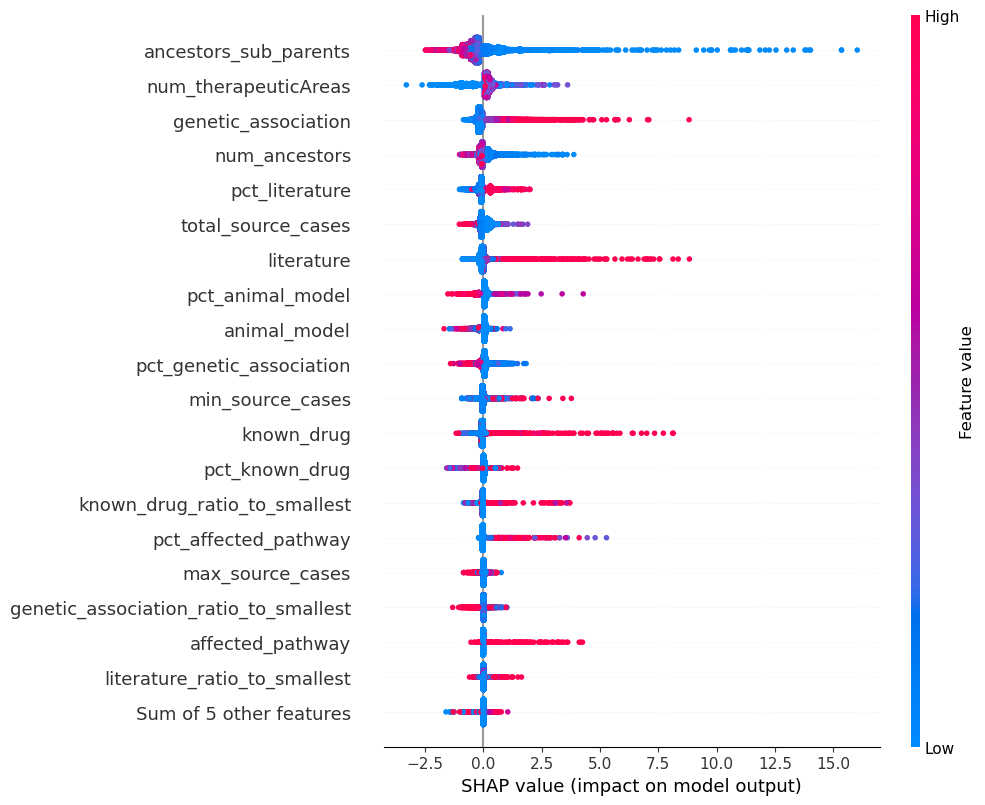

In [137]:
explainer = shap.Explainer(clf)
# shap_values = explainer(X)
shap_values = explainer(observations)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values,max_display=20)

In [138]:
%%time
preds = cross_val_predict(clf,X,y,#method='predict_proba',
#                           n_jobs=2,
                          groups=df["grp"],cv=GroupKFold(5))
# print("CV rocAUC",roc_auc_score(y, preds[:,1]))
# print(classification_report(y, preds[:,1]>=0.5))
regression_metrics(y,preds)


MAE (Mean absolute error): 1.74
Median absolute error 0.59
RMSE 5.18
R2 0.10
MAPE mean absolute percentage error 3189225216196241.000
CPU times: user 37min 8s, sys: 2min 37s, total: 39min 46s
Wall time: 3min 50s


* Get predictions

In [139]:
df["source"].nunique()

12

CPU times: user 801 ms, sys: 55.4 ms, total: 857 ms
Wall time: 113 ms


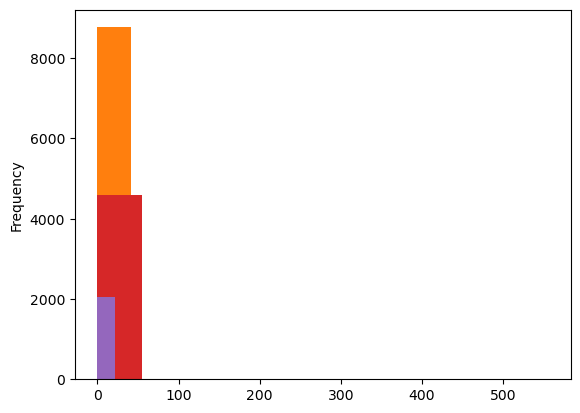

In [140]:
%%time
if GET_PREDS:
#     preds = cross_val_predict(clf,X,y,method='predict_proba',n_jobs=-2,cv=6)
#     df["pred_1"]  = preds[:,1]# ORIG, classification
    df["pred_1"]  = preds # wit hreg
    # df["pred_0"]  = preds[:,0]
#     df[["has_children","pred_1",]] # ,"pred_0"
    df["error"] = abs((df_res["has_children"] - df_res["pred_1"]).round(3))
    for s in df["source"].unique():     
        df_temp = df.loc[df["source"]==s]   
        if df_temp.shape[0]>50:
            y1 = df_temp["has_children"]
            y2 = df_temp["pred_1"]
            try:
                print(f"{s} RocAUC:",round(100*roc_auc_score(y1,y2),1))
                print("Mean error:",round(df_temp["error"].mean(),3))
                print(df_temp.shape[0],"cases;",round((y1.mean()/y.mean()),2),"target ratio over prior")
            except:(f"{s} error")
#             df_temp.groupby(["source"])["has_children"].plot(kind="kde")
            df_temp.groupby(["source"])["error"].plot(kind="hist")
#     display(df.groupby(["source"])["error"].plot(kind="hist")) # too many sources, overlaps
    df.drop(columns=["error"],errors="ignore",inplace=True)
        

In [141]:
if GET_PREDS:
    df_res = df[["id","name","has_children","pred_1","description"]].sort_values(["has_children","pred_1"],ascending=[True,False,])
    df_res["name"] = df_res["name"].str.lower()
    df_res = df_res.round(3)
    df_res.drop_duplicates(subset=["name"],inplace=True)
    
    ## pred error , by class
    df_res["error"] = abs((df_res["has_children"] - df_res["pred_1"]).round(3))
    # df_res.select_dtypes("number").round(1).drop_duplicates() # looks ok!
    df_res

In [142]:
# df_res.loc[df_res["name"].str.contains("volume|measurement",case=False)]#.describe() # 2809 rows - 10% of data. 9.5% has_children

df_res.loc[(df_res["name"].str.contains("volume|measurement",case=False))|
               (df_res["description"].str.contains("volume|measurement",case=False))][["name","description"]]

,name,description
7532,hypertrophy,Hypertrophy is the increase in the volume of a...
13686,endothelial dysfunction,"In vascular diseases, endothelial dysfunction ..."
7863,platelet count,The number of PLATELETS per unit volume in a s...
6852,latitude,A measurement that is the measure of the latit...
6939,longitude,A measurement that is the measure of the longi...
...,...,...
3541,normocytic anemia,Anemia in which the red blood cell volume is n...
9120,age,A temporal measurement of the time period elap...
11397,body weights and measures,"Measurements of the height, weight, length, ar..."
5457,anemia,"A reduction in the number of red blood cells, ..."


In [143]:
df_res["name"].str.lower().nunique()

17230

In [144]:
 df.loc[df["name"].str.contains("cystic fibrosis")]

,id,description,name,hasBroadSynonym,hasExactSynonym,hasRelatedSynonym,has_children,num_parents,num_ancestors,num_therapeuticAreas,...,pct_somatic_mutation,somatic_mutation_ratio_to_biggest,somatic_mutation_ratio_to_smallest,datasource_nunique,datasources_count,datatype_nunique,All_ICD_counts,f41202_ICD_counts,ICD10_all_freq,pred_1
17,MONDO_0009061,Cystic fibrosis (CF) is a genetic disorder cha...,cystic fibrosis,0,1,0,0,1,5,31,...,0.0,0.0,0.0,5.0,1433.0,2.0,NaN,NaN,NaN,7.726336
2701,MONDO_0009062,A rare genetic disease reported in two sibling...,cystic fibrosis-gastritis-megaloblastic anemia...,0,1,1,0,0,2,15,...,0.0,0.0,0.0,1.0,2.0,1.0,NaN,NaN,NaN,0.815469
9805,EFO_0004608,Cystic fibrosis associated meconium ileus is a...,cystic fibrosis associated meconium ileus,0,1,0,0,1,5,30,...,0.0,0.0,0.0,1.0,2.0,1.0,NaN,NaN,NaN,0.826531
17013,Orphanet_2575,None,cystic fibrosis - gastritis - megaloblastic an...,0,1,0,0,0,6,30,...,0.0,0.0,0.0,2.0,19.0,2.0,NaN,NaN,NaN,0.647832
17928,EFO_0009797,A spectrum of lung disorders that develop in p...,lung disease associated with cystic fibrosis,0,0,0,0,0,3,16,...,0.0,0.0,0.0,1.0,6.0,1.0,NaN,NaN,NaN,0.476803


In [146]:
df_res.loc[~((df_res["name"].str.contains("volume|measurement",case=False))|
               (df_res["description"].str.contains("volume|measurement",case=False)))].head(25).round(2).select_dtypes("O")

,id,name,description
3440,GO_0007568,aging,The gradual irreversible changes in structure ...
18805,OTAR_0000003,cyst,A sac-like closed membranous structure that ma...
7023,EFO_0000203,monoclonal gammopathy,A condition characterized by the abnormal pres...
4527,MONDO_0002839,leather-bottle stomach,A cancer-related condition in which the gastri...
10194,EFO_0005303,sudden infant death syndrome,Unexpected death in infancy which remains unex...
1476,MONDO_0000890,zika virus congenital syndrome,A congenital birth syndrome that arises from m...
11914,MONDO_0100091,inherited pseudoxanthoma elasticum,An inheritable form of pseudoxanthoma elasticu...
1478,MONDO_0001721,urethral intrinsic sphincter deficiency,None
10621,MONDO_0044782,esophageal ulcer,An ulcerated lesion in the esophageal wall.
6581,MONDO_0021180,acquired xanthinuria,Acquired xanthinuria is generally iatrogenic. ...


In [147]:
# df_res.to_csv("predictions_v2_openTarget_has_children.csv.gz",index=False,compression="gzip")

<AxesSubplot:>

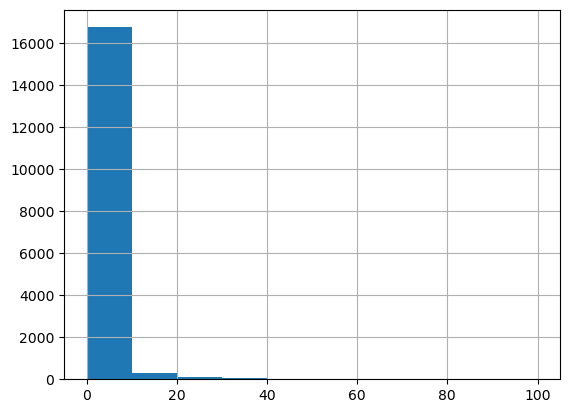

In [148]:
# df_res[["has_children","pred_1"]].plot().scatter()
# df_res[["has_children","pred_1","error"]].groupby("has_children").hist()
df_res[["has_children","pred_1","error"]]["has_children"].hist()

In [149]:
# df_res[["source","has_children","pred_1","error"]].groupby(["source","has_children"]).hist()

* get error by source / cat  e.g. orphanet

In [150]:
### df_res["err"] = df_res["has_children"]-df_res["pred_1"]
df_res.sort_values(["has_children","error"],ascending=[False,True])

,id,name,has_children,pred_1,description,error
7523,MONDO_0024255,genetic skin disease,100,21.813,An instance of skin disease that is caused by ...,78.187
7382,EFO_0000508,genetic disorder,100,21.046,Genetic diseases are diseases in which inherit...,78.954
11381,MONDO_0019117,genetic nervous system disorder,100,12.139,An instance of nervous system disease that is ...,87.861
7705,MONDO_0019054,congenital limb malformation,100,10.599,None,89.401
7541,MONDO_0015159,multiple congenital anomalies/dysmorphic syndr...,100,4.789,None,95.211
...,...,...,...,...,...,...
10194,EFO_0005303,sudden infant death syndrome,0,20.121,Unexpected death in infancy which remains unex...,20.121
4527,MONDO_0002839,leather-bottle stomach,0,27.280,A cancer-related condition in which the gastri...,27.280
7023,EFO_0000203,monoclonal gammopathy,0,27.661,A condition characterized by the abnormal pres...,27.661
18805,OTAR_0000003,cyst,0,29.068,A sac-like closed membranous structure that ma...,29.068


In [151]:
df_res.sort_values(["error"],ascending=[False])

,id,name,has_children,pred_1,description,error
11245,MONDO_0020119,x-linked syndromic intellectual disability,100,1.084,A syndromic intellectual disability with an X-...,98.916
5867,MONDO_0019589,syndromic genetic hearing loss,100,1.178,None,98.822
10116,MONDO_0019287,ectodermal dysplasia syndrome,100,1.236,The term ''ectodermal dysplasia'' defines a he...,98.764
10351,MONDO_0018454,dysostosis of genetic origin,100,1.714,An instance of dysostosis that is caused by a ...,98.286
3402,MONDO_0000508,syndromic intellectual disability,100,1.841,A intellectual disability that is part of a la...,98.159
...,...,...,...,...,...,...
1763,HP_0000364,hearing abnormality,4,4.001,An abnormality of the sensory perception of so...,0.001
7804,MONDO_0024519,renal hypodysplasia/aplasia 1,0,0.001,None,0.001
3409,MONDO_0008710,rab23-related carpenter syndrome,0,-0.001,Any Carpenter syndrome in which the cause of t...,0.001
9182,MONDO_0100148,x-linked complex neurodevelopmental disorder,4,4.001,A complex neurodevelopmental disorder that is ...,0.001


In [152]:
df_res["has_children"].describe()

count    17230.000000
mean         1.282472
std          5.449754
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        100.000000
Name: has_children, dtype: float64

In [153]:
df_res.sort_values(["has_children","pred_1",],ascending=[True,False]).head(15).iloc[:,0:4]

,id,name,has_children,pred_1
3440,GO_0007568,aging,0,39.987
18805,OTAR_0000003,cyst,0,29.068
7023,EFO_0000203,monoclonal gammopathy,0,27.661
4527,MONDO_0002839,leather-bottle stomach,0,27.280
10194,EFO_0005303,sudden infant death syndrome,0,20.121
1476,MONDO_0000890,zika virus congenital syndrome,0,19.830
11914,MONDO_0100091,inherited pseudoxanthoma elasticum,0,18.447
1478,MONDO_0001721,urethral intrinsic sphincter deficiency,0,18.444
10621,MONDO_0044782,esophageal ulcer,0,17.937
6581,MONDO_0021180,acquired xanthinuria,0,17.221


#### most errors - in cases of lots of children 
* errors isn't scaled.. Log may make things btter

In [155]:
df_res.sort_values(["has_children","pred_1",],ascending=[False,True]).head().iloc[:,0:4]

,id,name,has_children,pred_1
11245,MONDO_0020119,x-linked syndromic intellectual disability,100,1.084
5867,MONDO_0019589,syndromic genetic hearing loss,100,1.178
10116,MONDO_0019287,ectodermal dysplasia syndrome,100,1.236
10351,MONDO_0018454,dysostosis of genetic origin,100,1.714
3402,MONDO_0000508,syndromic intellectual disability,100,1.841


In [156]:
df_res.loc[df_res["has_children"]<40].sort_values(["has_children","pred_1",],ascending=[False,True]).head(15).iloc[:,0:4]

,id,name,has_children,pred_1
9609,MONDO_0018609,syndromic hereditary optic neuropathy,39,3.739
22854,Orphanet_330197,genetic multiple congenital anomalies/dysmorph...,39,4.915
18169,OTAR_0000018,"genetic, familial or congenital disease",39,7.345
9016,EFO_0000589,metabolic disease,38,33.096
2710,HP_0000271,abnormality of the face,37,1.105
6957,MONDO_0015338,syndromic craniosynostosis,37,1.771
10640,MONDO_0015905,syndromic dyslipidemia,36,1.031
13805,Orphanet_253,spondyloepiphyseal dysplasia and spondyloepime...,36,1.203
9699,MONDO_0043218,neurovascular disorder,36,5.187
9017,EFO_0000763,viral disease,36,15.526
